In [1]:
# More inports than nessasary...
import os
from pathlib import Path
import geopandas as gpd
import xarray as xr

# Block of imports needed for GRIDtool.grid_area_weighted_volume
import rasterio as rio
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt



mwb_flow_dir = r'C:\Users\CND905\Downloaded_Programs\mwb_flow'
os.chdir(mwb_flow_dir)
from prep.datafile import CreateInputFile
from prep.metdata import get_gridmet_for_polygons
# from prep.q_datafile import GetFlowData
from mwb_flow.model import WB_Model

import py3dep
from tqdm import tqdm
from config import GRIDMET_PARAMS
import GRIDtools as gt


Initializing mwb_flow.prep module.
Initializing mwb_flow module.


## Create a GeoDataframe 
Create a geodataframe by delinieating watershed at gage station coordinates. Add an ID column (catchmentID) for indexing rows of geodataframe.

<u>Improvments and outstanding work</u>
- Can the ID column be automated?


In [2]:
# # This is just a test
# pour_pnt = gpd.GeoDataFrame(
#     {
#         "name": ["Lolo_Catchment", "Bear_Creek_Catchment"]
#     },
#     geometry=[Point(-114.133170, 46.748808),
#               Point(-114.324042, 46.766956)],
#     crs=4326
# )

# watershed_gdf = gt.delineate_watershed(pour_pnt)
# watershed_gdf["catchmentID"] = ['06187915', '06187916']
# watershed_gdf

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,0,06187915,"POLYGON ((-110.00979 44.97979, -110.00979 44.9...",80.07184,Soda Butte,up,True,Soda Butte Creek,2962790,10070001001206,"[-110.00209575050293, 45.00290093138068]"


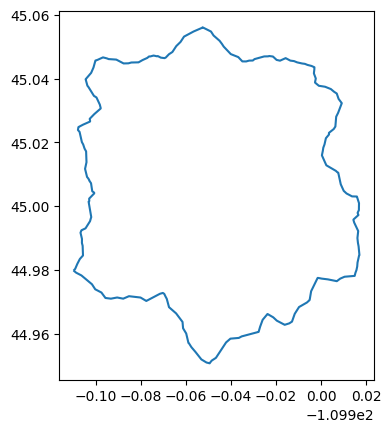

In [3]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Soda Butte"],
    },
    geometry=[Point(-110.0018722, 45.00283056)],
    crs=4326
)


watershed_gdf = gt.delineate_watershed(pour_pnt)
watershed_gdf["catchmentID"] = '06187915' # Does the code need an ID column as an int?

watershed_gdf.boundary.plot()
watershed_gdf

## Get Discharge Data
get the discharge data at a point using the GetFlowData class. This class has arguments to specify the data source and frequency it should be summarized at. 


<u>Improvments and outstanding work</u>
- Ideally, this could be a function that loops through geodataframe and pulls the discharge data.
- <strike>Why does code return an extra day on end of xarray.dataset?</strike>
- <strike>Update variable names and attr to reflect discharge in daily timesteps</strike>

In [4]:
dir = r'C:\Users\CND905\Downloaded_Programs\mwb_flow\Examples'
os.chdir(dir)

q_data = xr.open_dataarray('sodabutte_chumdata_discharge.nc')
q_data

<xarray.DataArray 'discharge' (time: 1461, location: 1)> Size: 12kB
[1461 values with dtype=float64]
Coordinates:
  * location  (location) <U8 32B '06187915'
  * time      (time) datetime64[ns] 12kB 2020-10-01 2020-10-02 ... 2024-09-30

## Get Meteorologic Data
Get the temperature and precipitation data for the polygon using the 'get_gridmet_for_polygons()' function.

<u>Improvments and outstanding work</u>
- <strike>Review method for calculating zonal stats of each polygon using xvec and exactextract</strike>
- <strike>Fix date range once timezone is fixed in q_data</strike>
- Review warning for spatial reference system

In [5]:
# met_data = get_gridmet_for_polygons(in_geom=watershed_gdf, gdf_index_col="catchmentID", start='1998-10-01', end='2024-12-31')
met_data = get_gridmet_for_polygons(in_geom=watershed_gdf, gdf_index_col="catchmentID", start='2020-10-01', end='2024-09-30')
met_data

c:\Users\CND905\.conda\envs\mwb_flow2\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
c:\Users\CND905\.conda\envs\mwb_flow2\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


<xarray.Dataset> Size: 47kB
Dimensions:        (location: 1, time: 1461)
Coordinates:
    lat            (location) float64 8B 45.0
    area           (location) float64 8B 80.07
  * location       (location) <U8 32B '06187915'
  * time           (time) datetime64[ns] 12kB 2020-10-01 ... 2024-09-30
Data variables:
    max_temp       (time, location) float64 12kB 288.0 287.3 ... 293.1 281.0
    min_temp       (time, location) float64 12kB 271.7 273.5 ... 277.9 270.2
    precip_volume  (time, location) float64 12kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    featureType:  timeSeries

## Create Model Input File
Get the temperature and precipitation data for the polygon using the 'get_gridmet_for_polygons()' function.

<u>Improvments and outstanding work</u>
- <strike>Review all units for accuracy.</strike> 

In [6]:
input_data = CreateInputFile(m_data=met_data, q_data=q_data).input_file
input_data

<xarray.Dataset> Size: 2kB
Dimensions:    (location: 1, time: 48)
Coordinates:
    lat        (location) float64 8B 45.0
    area       (location) float64 8B 80.07
  * location   (location) <U8 32B '06187915'
  * time       (time) datetime64[ns] 384B 2020-10-01 2020-11-01 ... 2024-09-01
Data variables:
    mo_temp    (time, location) float64 384B -0.7525 -5.26 ... 11.47 8.538
    mo_precip  (time, location) float64 384B 161.0 76.79 57.73 ... 56.13 65.14
    mo_dischg  (time, location) float64 384B 10.73 9.744 5.892 ... 19.54 17.77
Attributes:
    standard_name:  Monthly Temperature
    units:          Celsius

In [14]:
input_data.to_netcdf(r'C:\Users\CND905\Downloaded_Programs\mwb_flow\Examples\data\input_data.nc')

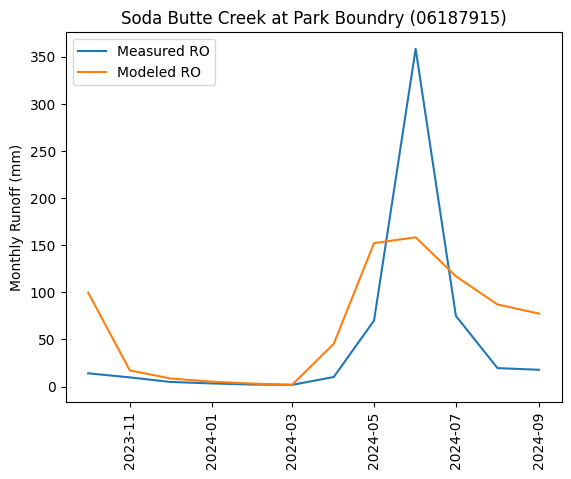

In [8]:
wsteps=36
results = WB_Model(data=input_data, init_steps=wsteps, soil_storage_cap=70, snow_temp=-5, rain_temp=0, direct_runoff_frac=0.8, melt_rate=0.7, surplus_runoff_fac=0.4).run_model()


x = results['time'].values
y1 = input_data['mo_dischg'].values[wsteps:,0]
y2 = results['total_runoff'].values[:,0]

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Soda Butte Creek at Park Boundry (06187915)")
plt.ylabel("Monthly Runoff (mm)")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)
plt.show()

In [15]:
results

<xarray.Dataset> Size: 896B
Dimensions:          (time: 12, location: 1)
Coordinates:
  * location         (location) <U8 32B '06187915'
  * time             (time) datetime64[ns] 96B 2023-10-01 ... 2024-09-01
Data variables:
    soil_storage     (time, location) float64 96B 2.553 2.279 ... 8.433 4.159
    surplus_storage  (time, location) float64 96B 35.84 21.51 ... 63.24 37.94
    snow_storage     (time, location) float64 96B 0.0 41.11 89.39 ... 0.0 0.0
    snowmelt         (time, location) float64 96B 0.0 7.013 0.0 ... 0.0 0.0 0.0
    AET              (time, location) float64 96B 19.26 7.977 ... 41.36 17.3
    surplus_runoff   (time, location) float64 96B 23.9 14.34 ... 42.16 25.29
    total_runoff     (time, location) float64 96B 99.66 17.09 ... 87.06 77.4
    precipitation    (time, location) float64 96B 94.71 51.57 ... 56.13 65.14
Attributes:
    featureType:  timeSeries

In [21]:
delt_s = (results['soil_storage'] + results['surplus_storage'] + results['snow_storage']).values[-1] - (results['soil_storage'] + results['surplus_storage'] + results['snow_storage']).values[0]
i = np.sum(results['precipitation']).values
o = np.sum(results['total_runoff']).values

o-i

np.float64(-70.42877645010174)

In [20]:
delt_s

array([3.70522613])

## Calibrate the Model

In [ ]:
import spotpy
class Spot_Setup(object):
    def __init__(self, data, func=None):

        self.params = [
            spotpy.parameter.Uniform("soil_stor_cap", low=0.01, high=200, optguess=40),
            spotpy.parameter.Uniform("temp_sno", low=-10, high=10, optguess=-5),
            spotpy.parameter.Uniform("temp_rain", low=-10, high=10, optguess=0),
            spotpy.parameter.Uniform("dr_frac", low=0.01, high=0.99, optguess=0.7),
            spotpy.parameter.Uniform("mlt_rate", low=0.01, high=0.99, optguess=0.7),
            spotpy.parameter.Uniform("sr_factor", low=0.01, high=0.99, optguess=0.9),
        ]

        self.pred_data = data
        self.obs_data = data['mo_dischg'].values[12:,0]
        
    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    def simulation(self, x):
        #Here the model is actualy started with a unique parameter combination that it gets from spotpy for each time the model is called
        xds = WB_Model(data=self.pred_data, init_per=12, soil_storage_cap=x[0], snow_temp=x[1], rain_temp=x[2], direct_runoff_frac=x[3], melt_rate=x[4], surplus_runoff_fac=x[5]).run_model()
        model_result = xds['total_runoff'].values[:,0]
        sim=[]
        for val in model_result:
            sim.append(val)
        return sim
    
    def evaluation(self):
        observations=self.obs_data
        return observations
    
    def objectivefunction(self, simulation, evaluation):
        objectivefunction= -spotpy.objectivefunctions.rmse(evaluation,simulation)      
        return objectivefunction

could add flexability to class init by making objectivefunction an argument

In [ ]:
os.chdir(r'C:\Users\CND905\Downloaded_Programs\mwb_flow\Examples\calibration\SB_rmse_100k')
print("New Working Directory:", os.getcwd())

results=[]
spot_setup=Spot_Setup(data=input_data)
rep=1000
timeout=10 #Given in Seconds

parallel = "seq"
dbformat = "csv"

# sampler=spotpy.algorithms.mc(spot_setup,parallel=parallel, dbname='SB_MC_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
# # print(describe(sampler))
# sampler.sample(rep)
# results.append(sampler.getdata())

# sampler=spotpy.algorithms.lhs(spot_setup,parallel=parallel, dbname='SB_LHS_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
# sampler.sample(rep)
# results.append(sampler.getdata())

sampler=spotpy.algorithms.mle(spot_setup, parallel=parallel, dbname='SB_MLE_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

# sampler=spotpy.algorithms.mcmc(spot_setup, parallel=parallel, dbname='SB_MCMC_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
# sampler.sample(rep)
# results.append(sampler.getdata())

sampler=spotpy.algorithms.sceua(spot_setup, parallel=parallel, dbname='SB_SCEUA_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep,ngs=4)
results.append(sampler.getdata())

sampler=spotpy.algorithms.sa(spot_setup, parallel=parallel, dbname='SB_SA_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

sampler=spotpy.algorithms.rope(spot_setup, parallel=parallel, dbname='SB_ROPE_rmse_100k', dbformat=dbformat,sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

# sampler=spotpy.algorithms.abc(spot_setup, parallel=parallel,   dbname='SB_ABC_rmse_100k', dbformat=dbformat,sim_timeout=timeout)
# sampler.sample(rep)
# results.append(sampler.getdata())

# sampler=spotpy.algorithms.fscabc(spot_setup, parallel=parallel, dbname='SB_FSABC_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
# sampler.sample(rep)
# results.append(sampler.getdata())


sampler=spotpy.algorithms.dream(spot_setup, parallel=parallel, dbname='SB_DREAM_rmse_100k', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep)
results.append(sampler.getdata())

In [ ]:
algorithms = ['mle','sceua','sa','rope', 'dream']
spotpy.analyser.plot_parametertrace_algorithms(results, algorithms, spot_setup, fig_name="SB_100k_rmse_parametertrace_algorithms.png")

In [ ]:
exres_pth = Path(r'C:\Users\CND905\Downloaded_Programs\mwb_flow\Examples\calibration\SB_rmse_100k\SB_MLE_rmse_100k.csv')
exres = pd.read_csv(exres_pth)
exres.values

In [ ]:
type(results[0])

In [ ]:
spotpy.analyser.get_best_parameterset(results[5])
# spotpy.analyser.get_best_parameterset(results[6])
# spotpy.analyser.get_best_parameterset(results[7])

post_results = spotpy.analyser.get_posterior(results[5])
spotpy.analyser.plot_parameter_uncertainty(post_results, input_data['mo_discharge'].values[36:,0])

# here = spotpy.analyser.calc_like(results[5], input_data['mo_discharge'].values[36:,0], objectivefunction=spotpy.objectivefunctions.nashsutcliffe)
# fig= plt.figure(1,figsize=(9,5))
# plt.plot(here)
# plt.ylabel('nashsutcliffe')
# plt.xlabel('Iteration')
# fig.savefig('SA on rmse 100k.png',dpi=300)
# plt.show()

In [ ]:
wsteps = 36
results = WB_Model(data_arr=input_data, init_per=wsteps,
                    soil_stor_cap=76.41064,
                      temp_sno=-3.7778792,
                        temp_rain=6.56942,
                          dr_frac=0.87404954,
                            mlt_rate=0.9635101,
                              sr_factor=0.68994063).run_model()


x = results['time'].values
y1 = input_data['mo_discharge'].values[wsteps:,0]
y2 = results['total_runoff'].values[:,0]

plt.xticks(rotation=90)
plt.plot(x, y1)
plt.plot(x, y2)
plt.title("Soda Butte Creek at Park Boundry (06187915)")
plt.ylabel("Monthly Runoff (mm)")
classes = ['Measured RO', 'Modeled RO']
plt.legend(labels=classes)
plt.show()